# Spinning rigid body

In [24]:
import sys; sys.path.append('../..')   # Allow relative imports from the parent folder

import numpy as np

from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

import jax 
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as jr

import optax

import equinox as eqx
import diffrax

from dynax import training
from dynax.function_models import LyapunovNN, OnsagerNetPotential, KolterLyapunovNN, FICNN, SkewSymmetricMatrix, ConstantSPDMatrix, MLP
from dynax.integration_models import ODESolver
from dynax.derivative_models import BaseModel, ISPHS, StableNODE
from dynax.losses import mse
from dynax.activations import smoothed_relu
from dynax.sphnn_tools import is_zero_gas_guarantee_valid

from pathlib import Path
import json

from functools import partial

from util import colors

ACTIVATIONS = dict(
    softplus = jax.nn.softplus,
    tanh = jax.nn.tanh,
    relu = jax.nn.relu,
)

INITIALIZERS = dict(
    he_uniform = jax.nn.initializers.he_uniform(),
    glorot_uniform = jax.nn.initializers.glorot_uniform(),
    zeros = jax.nn.initializers.zeros,
)

### Matplotlib Settings 
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

colors.set_custom_cycle()

model_style = {
    'true':     dict(c='black',                          ls='--',  lw=2.0, alpha=1.0),
    'sPHNN':    dict(c=colors.theme_colors['red'],       ls='-',   lw=2.0, alpha=0.8),
    'sPHNN-LM': dict(c=colors.theme_colors['darkblue'],  ls=':',   lw=1.0, alpha=0.8),
    'PHNN':     dict(c=colors.theme_colors['green'],     ls=':',   lw=1.0, alpha=0.8),
    'sNODE':    dict(c=colors.theme_colors['darkblue'],  ls=':',   lw=1.0, alpha=0.8),
    'NODE':     dict(c=colors.theme_colors['lightblue'], ls='-',   lw=1.0, alpha=0.8),
    'cPHNN':    dict(c=colors.theme_colors['orange'],    ls='-.',  lw=1.0, alpha=0.8),
}

model_names = {
    "sPHNN": "sPHNN",
    "sPHNN-LM": "sPHNN-LM",
    "PHNN": "PHNN",
    "NODE": "NODE",
    "sNODE": "sNODE",
    "cPHNN": "bPHNN",
}

PLOT_DPI = 200

## Model and training definitions

In [9]:
def get_rmse(model, ts, ys, us=None):
    ys_pred = jax.vmap(model, in_axes=(None, 0, 0))(ts, ys[:,0], us)
    return jnp.sqrt(jnp.mean(jnp.square(ys_pred - ys)))

model_colors = {
    'sPHNN':    colors.theme_colors['red'],
    'PHNN':     colors.theme_colors['green'],
    'NODE':     colors.theme_colors['darkblue'],
    'physical': colors.theme_colors['grey'],
}

def get_statistics(array):
    first_quartile, median, third_quartile = np.quantile(array, [0.25, 0.5, 0.75], axis=0)
    # Compute the interquartile mean
    interquartile_mask = np.logical_and(first_quartile <= array, array <= third_quartile)
    interquartile_mean = np.nanmean(np.where(interquartile_mask, array, np.nan), axis=0)
    statistics = dict(
        values = array,
        max = np.max(array, axis=0),
        min = np.min(array, axis=0),
        mean = np.mean(array, axis=0),
        first_quartile = first_quartile, 
        median = median, 
        interquartile_mean = interquartile_mean,
        third_quartile = third_quartile,
        std = np.std(array, axis=0),
    )
    return statistics

def integrate(func, y0, ts, args=None, **kwargs):

    stepsize_controller = kwargs.pop('stepsize_controller', diffrax.PIDController(rtol=1e-6, atol=1e-6))
    max_steps = kwargs.pop('max_steps', 4096)
    
    sol = diffrax.diffeqsolve(diffrax.ODETerm(func),
                              solver=diffrax.Tsit5(),
                              t0=ts[0], t1=ts[-1],
                              dt0=ts[1] - ts[0], y0=y0,
                              stepsize_controller=stepsize_controller,
                              args=args,
                              max_steps=max_steps,
                              saveat=diffrax.SaveAt(ts=ts))
    return sol.ys


def define_sPHNN_model(model_hyperparams: dict,
                       make_deriv_model: bool=False,
                       *, key):

    j_key, r_key, h_key= jr.split(key, 3)

    state_size = 3

    J = SkewSymmetricMatrix(state_size, activation=jnn.softplus, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)

    ficnn = FICNN(state_size, 'scalar', 
                  width=model_hyperparams['ficnn_width'],
                  depth=model_hyperparams['ficnn_depth'],
                  activation=jnn.softplus,
                  w_initializer=model_hyperparams['weight_initialization'], 
                  b_initializer=model_hyperparams['bias_initialization'],   
                  key=h_key)
    H = LyapunovNN(ficnn, minimum=jnp.zeros(state_size))
    model = ISPHS(H, J, R)
    if not make_deriv_model:
        model = ODESolver(model)

    return model

def define_sPHNN_LM_model(model_hyperparams: dict,
                          make_deriv_model: bool=False,
                          *, key):
    j_key, r_key, h_key, minimum_key = jr.split(key, 4)

    state_size = 3

    J = SkewSymmetricMatrix(state_size, activation=jnn.softplus, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)

    ficnn = FICNN(
        state_size,
        "scalar",
        width=model_hyperparams["ficnn_width"],
        depth=model_hyperparams["ficnn_depth"],
        activation=jnn.softplus,
        w_initializer=model_hyperparams["weight_initialization"],
        b_initializer=model_hyperparams["bias_initialization"],
        key=h_key,
    )
    _H = LyapunovNN(ficnn)
    initial_minimum = jax.nn.initializers.normal(
        model_hyperparams["minimum_initializer_std"]
    )(minimum_key, _H.minimum.shape)
    H = eqx.tree_at(lambda x: x.minimum, _H, initial_minimum)
    assert H.minimum_learnable, "Minimum is not learnable for sPHNN_LM"
    model = ISPHS(H, J, R)
    if not make_deriv_model:
        model = ODESolver(model)

    return model

def define_PHNN_model(model_hyperparams: dict,
                      make_deriv_model: bool=False,
                      *, key):

    j_key, r_key, h_key= jr.split(key, 3)

    state_size = 3

    J = SkewSymmetricMatrix(state_size, activation=jnn.softplus, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)

    H = MLP(in_size=state_size, out_size='scalar', 
            width_size=model_hyperparams['mlp_width'],
            depth=model_hyperparams['mlp_depth'],
            weight_initializer=model_hyperparams['weight_initialization'],
            bias_initializer=model_hyperparams['bias_initialization'],  
            activation=model_hyperparams['activation'],
            key=h_key)
    model = ISPHS(H, J, R)
    if not make_deriv_model:
        model = ODESolver(model)

    return model

def define_NODE_model(model_hyperparams: dict,
                      make_deriv_model: bool=False,
                      *, key):
    
    state_size = 3

    mlp = MLP(state_size, state_size, 
              width_size=model_hyperparams['mlp_width'],
              depth=model_hyperparams['mlp_depth'],
              weight_initializer=model_hyperparams['weight_initialization'],
              bias_initializer=model_hyperparams['bias_initialization'],  
              activation=model_hyperparams['activation'], 
              key=key)
    model = BaseModel(mlp, state_size)
    if not make_deriv_model:
        model = ODESolver(model)

    return model

def define_sNODE_model(model_hyperparams: dict,
                      make_deriv_model: bool=False,
                      *, key):
    
    state_size = 3

    mlp_key, ficnn_key = jr.split(key, 2)

    # Define the smoothed relu activation function
    sigma = partial(smoothed_relu, d=0.1)

    # Nominal dynamics
    mlp = MLP(state_size, state_size, 
              width_size=model_hyperparams['mlp_width'],
              depth=model_hyperparams['mlp_depth'],
              weight_initializer=model_hyperparams['weight_initialization'],
              bias_initializer=model_hyperparams['bias_initialization'],  
              activation=model_hyperparams['activation'],
              key=mlp_key)
    
    # Lyapunov function
    ficnn = FICNN(state_size, 'scalar', 
                  width=model_hyperparams['ficnn_width'],
                  depth=model_hyperparams['ficnn_depth'],
                  activation=sigma,
                  w_initializer=model_hyperparams['weight_initialization'], # Hardcoded old version: jnn.initializers.glorot_uniform(),
                  b_initializer=model_hyperparams['bias_initialization'],   # Hardcoded old version: jnn.initializers.normal(),
                  key=ficnn_key)
    lyapunov_nn = KolterLyapunovNN(ficnn, minimum=jnp.zeros(state_size), epsilon=model_hyperparams['epsilon'])

    # Final model
    model = StableNODE(mlp, lyapunov_nn, alpha=model_hyperparams['alpha'])
    if not make_deriv_model:
        model = ODESolver(model)

    return model

def define_cPHNN_model(model_hyperparams: dict,
                      make_deriv_model: bool=False,
                      *, key):

    j_key, r_key, h_key= jr.split(key, 3)

    state_size = 3

    J = SkewSymmetricMatrix(state_size, activation=jnn.softplus, key=j_key)
    R = ConstantSPDMatrix(state_size, initializer=jnn.initializers.zeros, key=r_key)

    H = OnsagerNetPotential(
        state_size, 
        width_size=model_hyperparams['mlp_width'],
        depth=model_hyperparams['mlp_depth'],
        activation=model_hyperparams['activation'],
        weight_initializer=model_hyperparams['weight_initialization'],
        bias_initializer=model_hyperparams['bias_initialization'],  
        beta=model_hyperparams['beta'], 
        beta_learnable=model_hyperparams['beta_learnable'], 
        key=h_key
    )

    model = ISPHS(H, J, R)
    if not make_deriv_model:
        model = ODESolver(model)

    return model


def train_template(deriv_model, 
                   deriv_training_data: tuple, deriv_validation_data: tuple|None,
                   traj_training_data: tuple, traj_validation_data: tuple|None,
                   training_hyperparams: dict,
                   weights_dir=None, overwrite=False,
                   loss_fn = mse,
                   *, key):
    
    model = ODESolver(deriv_model)
    try:
        model = training.load_weights(weights_dir/Path('weights.eqx'), model)
        history = training.load_history(weights_dir/Path('history.npz'))
    except FileNotFoundError:
        deriv_model, deriv_history = training.fit_derivative(
            deriv_model, *deriv_training_data,
            validation_data = deriv_validation_data,
            loss_fn         = loss_fn,
            batch_size      = training_hyperparams['deriv_batch_size'],
            steps           = training_hyperparams['deriv_steps'],
            optimizer       = optax.adam(training_hyperparams['deriv_learning_rate']),
            log_loss_every  = 100,
            key             = key
            )
        
        model = ODESolver(deriv_model, max_steps=10_000)

        model, traj_history = training.fit_trajectory(
            model, *traj_training_data,
            validation_data = traj_validation_data,
            loss_fn         = loss_fn,
            batch_size      = training_hyperparams['traj_batch_size'],
            steps           = training_hyperparams['traj_steps'],
            optimizer       = optax.adam(training_hyperparams['traj_learning_rate']),
            log_loss_every  = 100,
            key             = key
            )
        
        history = training.concatenate_histories(deriv_history, traj_history)

        training.save_weights(weights_dir/Path('weights'), model, overwrite)
        training.save_history(weights_dir/Path('history'), history, overwrite)

    return model, history

def evaluation_template(model, 
                        training_data: tuple, test_data: tuple,
                        metrics_dir: Path):
    
    # Load RMSE data if available, otherwise compute it
    try:
        error_measures = np.load(metrics_dir/Path('error_measures.npz'))
        error_measures = dict(error_measures)
    except FileNotFoundError:
        error_measures = {
            'test_rmse': get_rmse(model, *test_data),
            'train_rmse': get_rmse(model, *training_data),
        }
        np.savez(metrics_dir/Path('error_measures.npz'), **error_measures)

    return error_measures


def get_hyperparams(file: Path, default_hyperparamse: dict):
    file = Path(file)
    try:
        with open(file, 'r') as f:
            hyperparams = json.load(f)

        print('Loaded hyperparameters from JSON file.')
        return hyperparams

    except FileNotFoundError:
        file.parent.mkdir(parents=True, exist_ok=True)
        with open(file, 'w') as f:
            json.dump(default_hyperparamse, f, indent=4)
        print('No JSON file found. Saving specified hyperparameters.')
        return default_hyperparamse

## Generate the data

In [5]:
def euler_equations(t, ω, args):
    I, µ = args
    # I - *vector* of principal moments of inertia
    # µ - drag coefficient
    
    # τ = µ*jnp.linalg.norm(ω)*ω  # Friction torque
    τ = µ*ω  # Friction torque
    ω_t = (1/I) * jnp.cross(I*ω, ω) - τ

    return ω_t


I = jnp.array([1.,2.,3.])       # I - *vector* of principal moments of inertia

args = (I, 0.01)

### Generate data
key = jr.key(0)

## Training data
ts_train = jnp.linspace(0, 50, 1000)
x0s_train = jr.uniform(key, shape=(10,3))
x0s_train = x0s_train**2
xs_train = jax.vmap(integrate, in_axes=(None, 0, None, None))(euler_equations, x0s_train, ts_train, args)
# Differentiate data
x_ts_train = jax.vmap(jax.vmap(euler_equations, in_axes=(None, 0, None)), in_axes=(None, 0, None))(ts_train, xs_train, args)
# Reshape for derivative fitting
xs_train_flat = jnp.reshape(xs_train, shape=(-1, 3))
x_ts_train_flat = jnp.reshape(x_ts_train, shape=(-1, 3))

train_data_traj  = (ts_train, xs_train)
train_data_deriv = (xs_train_flat, x_ts_train_flat)

# Test data
ts_test = jnp.linspace(0, 200, 1000)
x0s_test = jr.uniform(key, shape=(10,3))
x0s_test = x0s_train**2
xs_test = jax.vmap(integrate, in_axes=(None, 0, None, None))(euler_equations, x0s_test, ts_test, args)
# Differentiate data
x_ts_test = jax.vmap(jax.vmap(euler_equations, in_axes=(None, 0, None)), in_axes=(None, 0, None))(ts_test, xs_test, args)
# Reshape for derivative fitting
xs_test_flat = jnp.reshape(xs_test, shape=(-1, 3))
x_ts_test_flat = jnp.reshape(x_ts_test, shape=(-1, 3))

vali_data_traj  = ((ts_test, xs_test[:,0], None), xs_test)
vali_data_deriv = ((None, xs_test_flat, None), x_ts_test_flat)

test_data_traj  = (ts_test, xs_test)
test_data_deriv = (xs_test_flat, x_ts_test_flat)

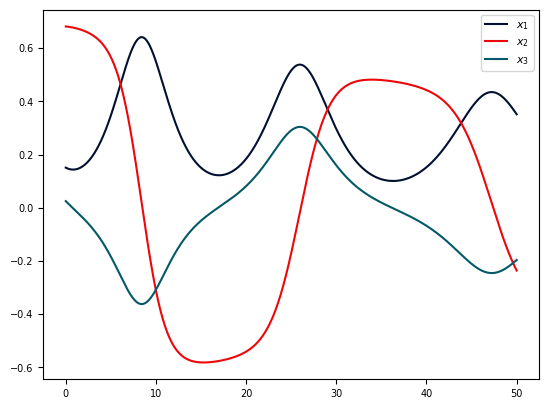

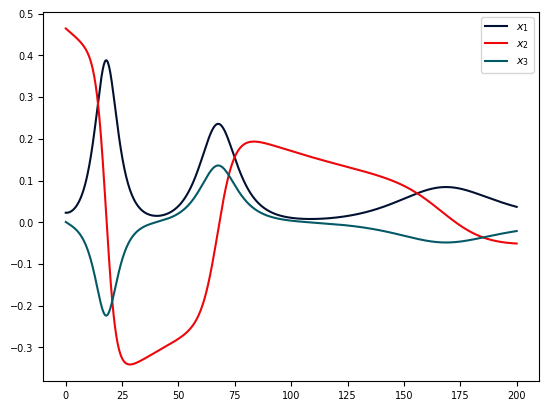

In [6]:
# %% Plot data

use_batch = 0
plt.plot(ts_train, xs_train[use_batch], label=[f'$x_{i}$' for i in range(1,4)])
plt.legend()
plt.show()

use_batch = 0
plt.plot(ts_test, xs_test[use_batch], label=[f'$x_{i}$' for i in range(1,4)])
plt.legend()
plt.show()

## Set Hyperparameters
The following sets the hyperparameters for the experiment and/or the directory to save/load the trained models to.

In [10]:
# Directory of the files for saving or loading
save_dir = Path(R'results/run_0')

default_hyperparams = {
    'meta': dict(
        description = 'Now I use float 64 for precision.',
        num_instances = 10,
    ),
    'sPHNN': dict(
        ficnn_width             = 16,
        ficnn_depth             = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
    ),
    'PHNN': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'NODE': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus'
    ),
    'sNODE': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        activation              = 'softplus',
        ficnn_width             = 16,
        ficnn_depth             = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        alpha                   = 0.01,
        epsilon                 = 0.1,
    ),
    'cPHNN': dict(
        mlp_width               = 16,
        mlp_depth               = 2,
        weight_initialization   = 'glorot_uniform',
        bias_initialization     = 'zeros',
        activation              = 'softplus',
        beta                    = 0.1,
        beta_learnable          = False,
    ),
    'training': dict(
        deriv_batch_size      = 128,
        deriv_steps           = 50000,
        deriv_learning_rate   = 1e-3,
        traj_batch_size       = 32,
        traj_steps            = 0,
        traj_learning_rate    = 1e-4,
    ),
}

# Load hyperparameters / Save hyperparameters if new experiment
hyperparams = get_hyperparams(save_dir/'hyperparameters.json', default_hyperparams)

# Substitute the activations and intialization schemes
for model in hyperparams.values():
    if 'activation' in model.keys():
        model['activation'] = ACTIVATIONS[model['activation']]
    if 'weight_initialization' in model.keys():
        model['weight_initialization'] = INITIALIZERS[model['weight_initialization']]
    if 'bias_initialization' in model.keys():
        model['bias_initialization'] = INITIALIZERS[model['bias_initialization']]



Loaded hyperparameters from JSON file.


## Train (or load) models


In [11]:
num_instances = hyperparams['meta']['num_instances']
results = {}

# Complete model definitions to include data specific information and collect the functions in a dict
model_definitions = {
    'sPHNN':    partial(define_sPHNN_model, 
                        make_deriv_model = True,
                        model_hyperparams      = hyperparams['sPHNN']),
    'sPHNN-LM':    partial(define_sPHNN_LM_model, 
                        make_deriv_model = True,
                        model_hyperparams      = hyperparams['sPHNN-LM']),
    'cPHNN':     partial(define_cPHNN_model,
                        make_deriv_model = True,
                        model_hyperparams      = hyperparams['cPHNN']),
    'PHNN':     partial(define_PHNN_model,
                        make_deriv_model = True,
                        model_hyperparams      = hyperparams['PHNN']),
    'NODE':     partial(define_NODE_model,
                        make_deriv_model = True,
                        model_hyperparams      = hyperparams['NODE']),
    'sNODE':     partial(define_sNODE_model,
                        make_deriv_model = True,
                        model_hyperparams      = hyperparams['sNODE']),
}

# Complete training definition
train_model = partial(train_template,
                      deriv_training_data = train_data_deriv,
                      deriv_validation_data = vali_data_deriv,
                      traj_training_data = train_data_traj,
                      traj_validation_data = vali_data_traj,
                      training_hyperparams = hyperparams['training'],
                      loss_fn = mse)

evaluate_model = partial(evaluation_template,
                         training_data = train_data_traj,
                         test_data = test_data_traj)

# Load/Train the models

for model_name, definition in model_definitions.items():
    print(f'{model_name:-^40}')


    def train_instance(instance_id: int):
        key = jr.key(instance_id)
        model_key, loader_key = jr.split(key, 2)

        # Define the model
        _model = definition(key=model_key)

        # Train or load the model
        weights_dir=save_dir/f'{model_name}'/f'instance_{instance_id}'
        _model, history = train_model(_model,
                                      weights_dir=weights_dir,
                                      key=loader_key)
        model = training.resolve_constraints(_model)


        # Evaluate the model
        error_measures = evaluate_model(model, 
                                        metrics_dir=weights_dir)

        instance_result = dict(
            model = model,
            history = history,
        ) | error_measures

        return instance_result
    
    # Sequential trianing
    results[model_name] = []
    for i in range(num_instances):
        results[model_name].append(train_instance(i))

-----------------sPHNN------------------
----------------sPHNN-LM----------------
-----------------cPHNN------------------
------------------PHNN------------------
------------------NODE------------------
-----------------sNODE------------------


#### Check if all sPHNNs are 0-GAS (Globally asymptotically stable)

In [16]:
for model_name in ['sPHNN', 'sPHNN-LM']:
    all_passed = True
    for n, instance_result in enumerate(results[model_name]):
        isphs = instance_result['model'].derivative_model
        if not is_zero_gas_guarantee_valid(isphs, 1e-6):
            all_passed = False
            print(f'{model_name}, instance {n} might not be 0-GAS.')
if all_passed:
    print(f'All {model_name} instances are 0-GAS')

All sPHNN-LM instances are 0-GAS


## Evaluation
#### Box/Violinplot

In [21]:
results["sPHNN"][0].keys()

dict_keys(['model', 'history', 'test_rmse', 'train_rmse'])

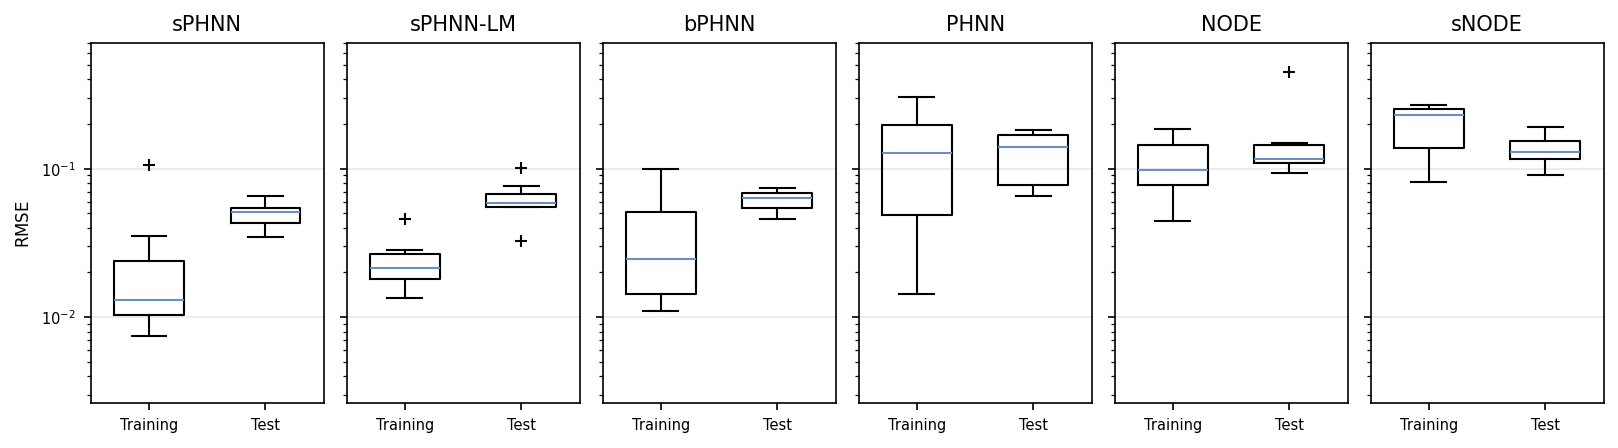

In [25]:
violinplot = False      # True -> Violinplot, False > Boxplot
colorful = False

plot_rmse_data = {}
for model_type, instances in results.items():
    plot_rmse_data[model_type] = [
        [inst['rmse_train'] if model_type == "sPHNN-LM" else inst['train_rmse'] for inst in instances],
        [inst['rmse_test'] if model_type == "sPHNN-LM" else inst['test_rmse'] for inst in instances],
    ]

n_results = len(plot_rmse_data)
fig, axes = plt.subplots(1, n_results, figsize=(1.8*n_results, 3), dpi=150, sharey=True)
# fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
for ax, (model_type, rmses) in zip(axes, plot_rmse_data.items()):

    if violinplot:
        vp = ax.violinplot(rmses,
                  showextrema=True, showmeans=False, showmedians=True)
        plt.setp(vp['cmedians'], color='red')
    else:
        bp = ax.boxplot(rmses, notch=False, sym='+', vert=True, widths=(0.6, 0.6))
        plt.setp(bp['medians'], color=model_style[model_type]['c'] if colorful else colors.theme_colors['lightblue'])

    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)

    ax.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title=model_names[model_type],
        # xlabel='Data',
        ylabel=R'$\text{RMSE}$' if ax == axes[0] else '',
        xticks=[1,2],
        xticklabels=['Training', 'Test'],
        ylim=[None, 0.7],
        yscale='log',
    )

fig.tight_layout()
plt.show()

#### Plot training data with predictions

Computing results for sPHNN
Computing results for sPHNN-LM
Computing results for cPHNN
Computing results for PHNN
Computing results for NODE
Computing results for sNODE


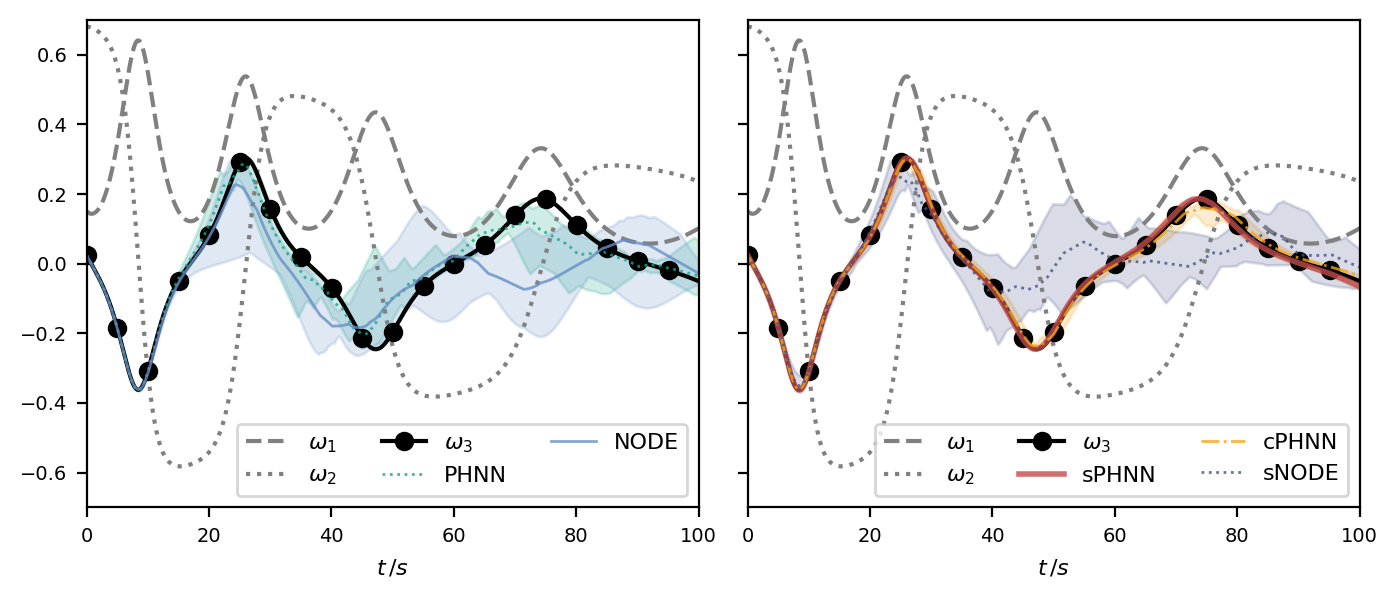

In [26]:
def get_prediction_statistics(ts, y0):
    ys_true = integrate(euler_equations, y0, ts, args)

    use_model_types = ['sNODE', 'sPHNN', 'NODE', 'PHNN', 'cPHNN']

    prediction_data = {}
    error_data = {}
    for model_type, model_results in results.items():
        print(f'Computing results for {model_type}')
        if model_type not in use_model_types:
            continue
        ys_preds = np.empty((len(model_results), ts_eval.shape[0], 3))
        for n, instance_result in enumerate(model_results):
            model = instance_result['model']
            ys_pred = model(ts_eval, y0_eval, None)
            ys_preds[n] = ys_pred

        # Calculate RMS
        example_mses = jnp.sqrt(jnp.mean(jnp.square(ys_preds - ys_true), axis=-1))
        error_data[model_type] = get_statistics(example_mses)

        prediction_data[model_type] = get_statistics(ys_preds)

    return prediction_data, error_data, ys_true


y0_eval = x0s_train[0] 
ts_eval = jnp.linspace(0, 100, 1000)
prediction_data, error_data, ys_true = get_prediction_statistics(ts_eval, y0_eval)

# Plot the prediction
plot_x_idx = [2]
model_in_subplot = {'sPHNN': 1, 'cPHNN':1, 'PHNN': 0, 'NODE': 0, 'sNODE': 1}

num_subplots = np.unique(list(model_in_subplot.values())).size
fig, axes = plt.subplots(1, num_subplots, sharey=True, figsize=(3.5*num_subplots, 3), dpi=PLOT_DPI)

for ax in axes:
    ax.plot(ts_eval, ys_true[:,0], ls='--', c='gray',  label='$\omega_1$')
    ax.plot(ts_eval, ys_true[:,1], ls=':',  c='gray',  label='$\omega_2$')
    ax.plot(ts_eval, ys_true[:,2], ls='-',  c='black', label='$\omega_3$', marker='o', markevery=50)

    ax.set(
        axisbelow=True,
        xlabel=R'$t\,/s$',
        ylabel=R'$x_2\,/V$' if n==0 else '',
        ylim=[-0.7, 0.7],
        xlim=[ts_eval.min(), ts_eval.max()],
    )

for model_type, model_data in prediction_data.items():
    ax_idx = model_in_subplot[model_type]
    ax = axes[ax_idx]
    ax.plot(ts_eval, 
            model_data['interquartile_mean'][:,plot_x_idx],
            # model_data['values'][0,:,0],
            **model_style[model_type],
            label=[model_type] + (len(plot_x_idx) - 1)*[None]
            )
    for n, (q1, q3) in enumerate(zip(model_data['first_quartile'].T, model_data['third_quartile'].T)):
        if n  in list(plot_x_idx):
            ax.fill_between(ts_eval, q1, q3, 
                            alpha=0.2, zorder=1, color=model_style[model_type]['c'], 
                            )

for ax in axes:
    ax.legend(ncols=3)    

plt.tight_layout()
fig.patch.set_alpha(0.)     # Transparent background
# plt.savefig(FIG_IMG_DIR/f'prediction.png', bbox_inches='tight')
plt.show()

#### Plot energy prediction

# of valid sPHNN predictions: 10
# of valid sPHNN-LM predictions: 10
# of valid cPHNN predictions: 10
# of valid PHNN predictions: 10
# of valid NODE predictions: 10
# of valid sNODE predictions: 10


C:\Users\roth\AppData\Local\Temp\ipykernel_42520\2300774988.py:149: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


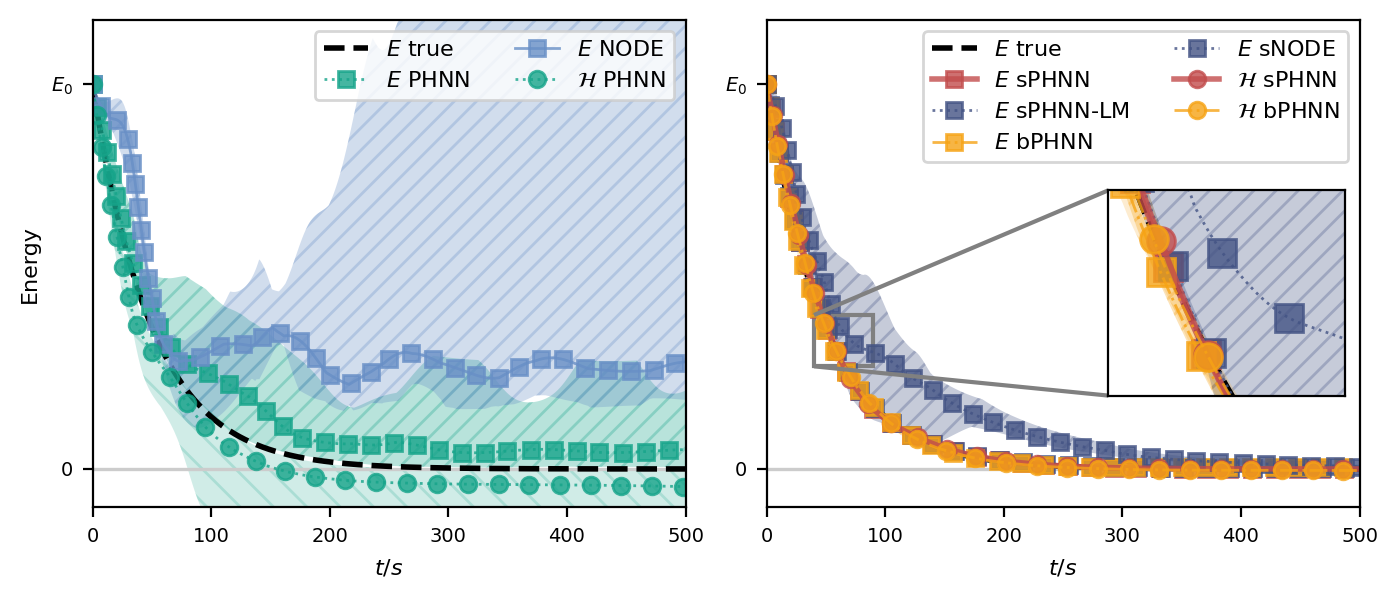

In [28]:
def compute_energy(ys):
    return 0.5*np.dot(np.square(ys), args[0])

def get_energy_statistics(ts, y0):
    ys_true = integrate(euler_equations, y0, ts, args)
    E_true = compute_energy(ys_true)

    true_data = {
        'E_true': E_true,
        'ys_true': ys_true
    }

    prediction_data = {}
    H_data = {}
    E_data = {}
    for model_type, model_results in results.items():
        ys_preds = []
        H_preds = []
        E_preds = []
        for n, instance_result in enumerate(model_results):
            model = instance_result['model']
            try:
                model = instance_result['model']
                ys_pred = model(ts_eval, y0_eval, None)
                ys_preds.append(ys_pred)
                E_preds.append(compute_energy(ys_pred))
                if model_type in ['sPHNN', 'PHNN', 'cPHNN']:
                    H_0 = model.derivative_model.hamiltonian(jnp.zeros(3))
                    H_pred = jax.vmap(model.derivative_model.hamiltonian)(ys_pred)
                    H_pred_shift = H_pred-H_0
                    H_preds.append( H_pred_shift * (E_true[0] / H_pred_shift[0]) )
                
            except:
                print(f'{model_type}, instance {n} faild to integrate.')

        ys_preds    = np.stack(ys_preds, axis=0)
        E_preds     = np.stack(E_preds, axis=0)
        print(f'# of valid {model_type} predictions: {ys_preds.shape[0]}')

        prediction_data[model_type] = get_statistics(ys_preds)
        E_data[model_type] = get_statistics(E_preds)
        if H_preds:
            H_preds     = np.stack(H_preds, axis=0)
            H_data[model_type] = get_statistics(H_preds)

    return prediction_data, H_data, E_data, true_data


y0_eval = jnp.array([0.1, 0.1, 0.1]) 
ts_eval = jnp.linspace(0, 500, 1000)
prediction_data, H_data, E_data, true_data = get_energy_statistics(ts_eval, y0_eval)


fig, axes = plt.subplots(1, 2, figsize=(7,3), dpi=PLOT_DPI)

ax_per_model = {
    'sPHNN': axes[1],
    'sPHNN-LM': axes[1],
    'PHNN': axes[0],
    'NODE': axes[0],
    'sNODE': axes[1],
    'cPHNN': axes[1],
}

for ax in axes:
    ax.axhline(y = 0, linestyle = '-', c=colors.theme_colors['grey'], lw=1.2) 
    ax.plot(ts_eval, true_data['E_true'], 
            **model_style['true'],
            label='$E$ true')
for model_type, model_data in E_data.items():
    ax = ax_per_model[model_type]
    ax.plot(ts_eval, model_data['interquartile_mean'], 
                **model_style[model_type],
                marker='s', markevery=0.03,
                label=f'$E$ {model_names[model_type]}')
    ax.fill_between(ts_eval, model_data['first_quartile'], model_data['third_quartile'], 
                    alpha=0.3, zorder=1,
                    facecolor=model_style[model_type]['c'], 
                    edgecolor=colors.scale_lightness(model_style[model_type]['c'], 1.0),
                    hatch=R"///", lw=0,
                    # label=f'{model_type} Energy'
                    )
for model_type, model_data in H_data.items():
    ax = ax_per_model[model_type]
    ax.plot(ts_eval, model_data['interquartile_mean'], 
                **model_style[model_type],
                marker='o', markevery=0.04,
                label=[R'$\mathcal{H}$ ' + f'{model_names[model_type]}'])
    ax.fill_between(ts_eval, model_data['first_quartile'], model_data['third_quartile'], 
                    alpha=0.2, zorder=1, color=model_style[model_type]['c'], 
                    facecolor=model_style[model_type]['c'], 
                    edgecolor=colors.scale_lightness(model_style[model_type]['c'], 1.0),
                    hatch=R'\\', 
                    lw=0,
                    # label=f'{model_type} Hamiltonian'
                    )
    
## Plot zoomed in area

axins = zoomed_inset_axes(axes[1], zoom=4, 
                          loc='center right', bbox_to_anchor=(0.995, 0.44), bbox_transform=axes[1].transAxes)
axins.plot(ts_eval, true_data['E_true'], 
            **model_style['true'],
            label='$E$ true')
for model_type, model_data in E_data.items():
    if ax_per_model[model_type] == axes[0]:
        continue
    axins.plot(ts_eval, model_data['interquartile_mean'], 
                **model_style[model_type],
                marker='s', markevery=0.3, markersize=10,
                label=f'$E$ {model_names[model_type]}')
    axins.fill_between(ts_eval, model_data['first_quartile'], model_data['third_quartile'], 
                    alpha=0.3, zorder=1,
                    facecolor=model_style[model_type]['c'], 
                    edgecolor=colors.scale_lightness(model_style[model_type]['c'], 1.0),
                    hatch=R"///", lw=0,
                    )
for model_type, model_data in H_data.items():
    if ax_per_model[model_type] == axes[0]:
        continue
    axins.plot(ts_eval, model_data['interquartile_mean'], 
                **model_style[model_type],
                marker='o', markevery=0.4, markersize=10,
                label=[R'$\mathcal{H}$ ' + f'{model_names[model_type]}'])
    axins.fill_between(ts_eval, model_data['first_quartile'], model_data['third_quartile'], 
                    alpha=0.2, zorder=1, color=model_style[model_type]['c'], 
                    facecolor=model_style[model_type]['c'], 
                    edgecolor=colors.scale_lightness(model_style[model_type]['c'], 1.0),
                    hatch=R'\\', 
                    lw=0,
                    )
axins.set(
    xlim=[40, 90], ylim=[0.0080, 0.0120],
    xticks=[], yticks=[],
    )
mark_inset(axes[1], axins, loc1=2, loc2=3, fc="none", ec="0.5", lw=1.5)

for ax in axes:
    ax.set(
        yscale='linear',
        ylabel = 'Energy' if ax==axes[0] else '',
        xlabel = '$t/s$',
        xlim=[-0, ts_eval.max()],
        ylim=[-0.003, 0.035],
        yticks=[0, 0.03],
        yticklabels=['0', '$E_0$'],
    )
    ax.legend(loc='upper right', ncol=2)
plt.tight_layout()
plt.show()